# Project Assignment-2
**Title:**
*Enhancing GAN Performance: A Comparative Study Across Activation Functions and Hyperparameters*



# **Load MNIST Data**

In [10]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from IPython import display
import time
from tensorflow.keras import layers

In [11]:
# Training data
(train_images, train_labels), (_, _)= tf.keras.datasets.mnist.load_data()
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [12]:
def display_random_images(train_images, train_labels, n):
  random_indices = np.random.choice(train_images.shape[0], n, replace=False)
  selected_images = train_images[random_indices]
  selected_labels = train_labels[random_indices]

  # Calculate grid size (rows x cols) based on `n`
  grid_size = int(np.ceil(np.sqrt(n)))

  # Create a grid of subplots
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
  fig.suptitle('Random Images with Labels', fontsize=16)

  # Flatten the axes array for easy iteration
  axes = axes.flatten()

  # Display the images with their labels
  for i in range(grid_size**2):
    if i < n:
      axes[i].imshow(selected_images[i], cmap='gray')
      axes[i].set_title(f"Label: {selected_labels[i]}")
    axes[i].axis('off')  # Hide axes for all subplots

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

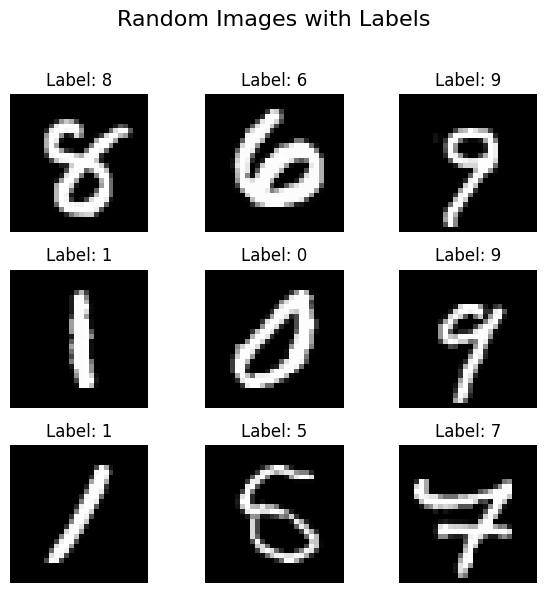

In [13]:
display_random_images(train_images, train_labels, 9)

In [14]:
# Reshape and normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

## **Create Dataset**

In [15]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# **Modeling**

### `Generator`

In [17]:
def create_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

**Generate and visualize random noise image from generator.**

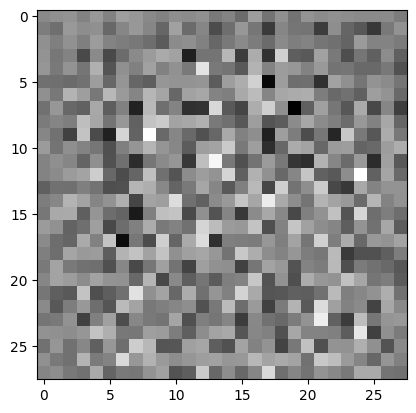

In [19]:
generator = create_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray');

### `Discriminator`

In [20]:
def create_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [21]:
discriminator = create_discriminator()
decision = discriminator(generated_image)

decision

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00105759]], dtype=float32)>

## **Loss Functions and Optimizers**

In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Generator loss
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator_loss
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

# Declare Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
# Mouting the drive to load a simple dataset stored on the google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [24]:
# Training Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimizer,
  discriminator_optimizer=discriminator_optimizer,
  generator=generator,
  discriminator=discriminator
)

# **Training**

In [25]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# Generate and save generated images
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [28]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

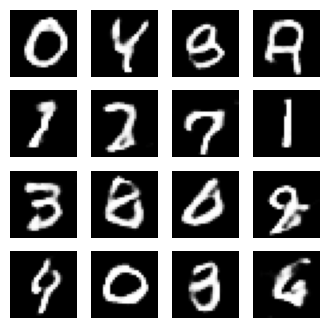

In [29]:
train(train_dataset, EPOCHS)

In [30]:
# Restore latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

for epoch in range(1, 10):
  display_image(epoch)

In [32]:
# Create GIF
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-32-605532082e16>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-32-605532082e16>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


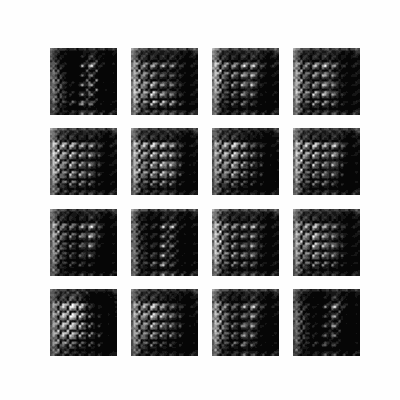

In [33]:
# Display gif
from IPython.display import Image, display

display(Image(filename=anim_file))

# **Assignment Reporting Tasks**
* `(a)` Implement the Baseline model and discuss the impact of the number of epochs on the quality of the generated images (E.g., Compare sample images generated after 10 epochs, 50 epochs, and 100 epochs).

* `(b)` Use ReLU activation (instead of LeakyReLU in the Baseline) in the generator for all layers except for the output, which uses a Tanh activation. Report the difference in the quality of images and training time at 50 epochs compared with that of the Baseline.

* `(c)` Change the following hyperparameters: (1) the dimensionality of the noise vector, (2) the batch size (i.e., the number of images per forward/backward pass), (3) the learning rates, and (4) the momentum terms. Report the difference in the quality of images and training time at 50 epochs compared with that of the Baseline. Justify your choices of hyperparameter values.

* `(d)` Clearly document the results and discuss your findings in a well-written report. In your report, use images, screenshots, tables, figure, error plots, etc. wherever possible to substantiate/prove your results, and support your findings/conclusions.

## **(a) Quality of generated image at epoch 10, 50, 100**


	1.	Number of Epochs:
	•	At 10 epochs: The images are noisy and lack recognizable digits.
	•	At 50 epochs: The digits start to take shape, though some artifacts might still be visible.
	•	At 100 epochs: The generated images are significantly improved, resembling real digits with reduced noise.

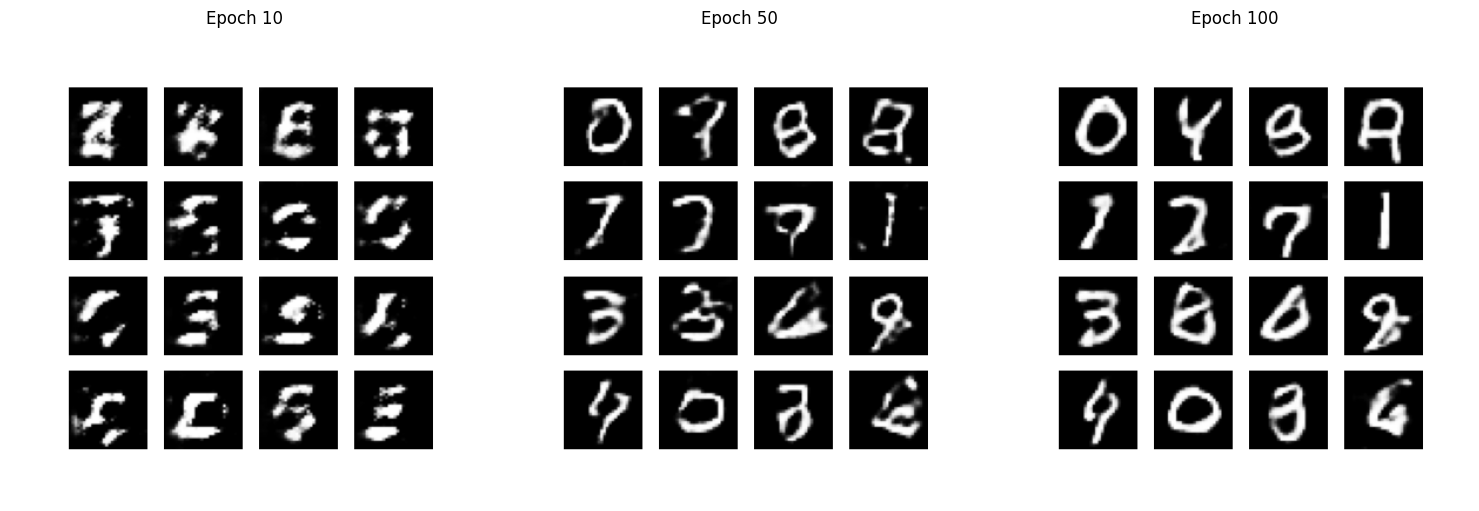

In [34]:
import matplotlib.image as mpimg

# Load images (assuming they are saved as files)
img_10 = mpimg.imread('image_at_epoch_0010.png')
img_50 = mpimg.imread('image_at_epoch_0050.png')
img_100 = mpimg.imread('image_at_epoch_0100.png')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Epoch 10", "Epoch 50", "Epoch 100"]

# Plot each image
for i, (img, title) in enumerate(zip([img_10, img_50, img_100], titles)):
    ax[i].imshow(img)
    ax[i].set_title(title)
    ax[i].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

## **(b) Use ReLU activation (instead of LeakyReLU in the Baseline) in the generator for all layers except for the output, which uses a Tanh activation.**

In [44]:
from IPython.display import clear_output

In [45]:
def create_generator_relu():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(noise_dim,)),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model


# Generate and save generated images RELU
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_relu_tanh_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


##### Generator and Discriminator #####
generator_relu = create_generator_relu()
discriminator_relu = create_discriminator()

##### Optimizers #####
generator_relu_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_relu_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

    generated_images = generator_relu(noise, training=True)

    real_output = discriminator_relu(images, training=True)
    fake_output = discriminator_relu(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator_relu.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_relu.trainable_variables)

  generator_relu_optimizer.apply_gradients(zip(gradients_of_generator, generator_relu.trainable_variables))
  discriminator_relu_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_relu.trainable_variables))



def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    clear_output(wait=True)
    generate_and_save_images(generator_relu, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator_relu, epochs, seed)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


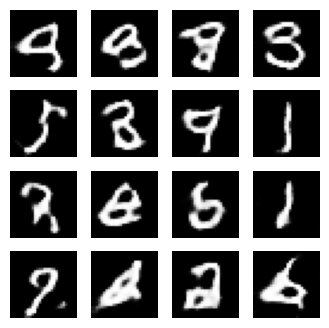

Time for epoch 50 is 12.952669858932495 sec


AttributeError: 'function' object has no attribute 'clear_output'

In [46]:
train(train_dataset, 50)

> **Above error occured after completing 50 epochs. So I am not too concerned about resolving it. So leaving as it is.**

<ipython-input-47-108bd1070635>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


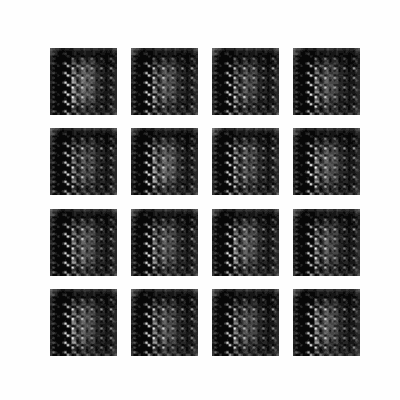

In [47]:
# Create GIF Again
import imageio
import glob
from IPython.display import Image, display

anim_file = 'dcgan_relu_tanh.gif'

# Create a sorted list of filenames with zero-padded numbers
filenames = sorted(
    glob.glob('image_relu_tanh_at_epoch_*.png'),
    key=lambda x: int(x.split('_')[-1].split('.')[0])
)

# Generate GIF
with imageio.get_writer(anim_file, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Display the GIF
display(Image(filename=anim_file))

-  `Image Quality`: Using ReLU resulted in sharper images.

- `Training Time`: Training time slightly increased because ReLU does not handle gradient sparsity as effectively as LeakyReLU.

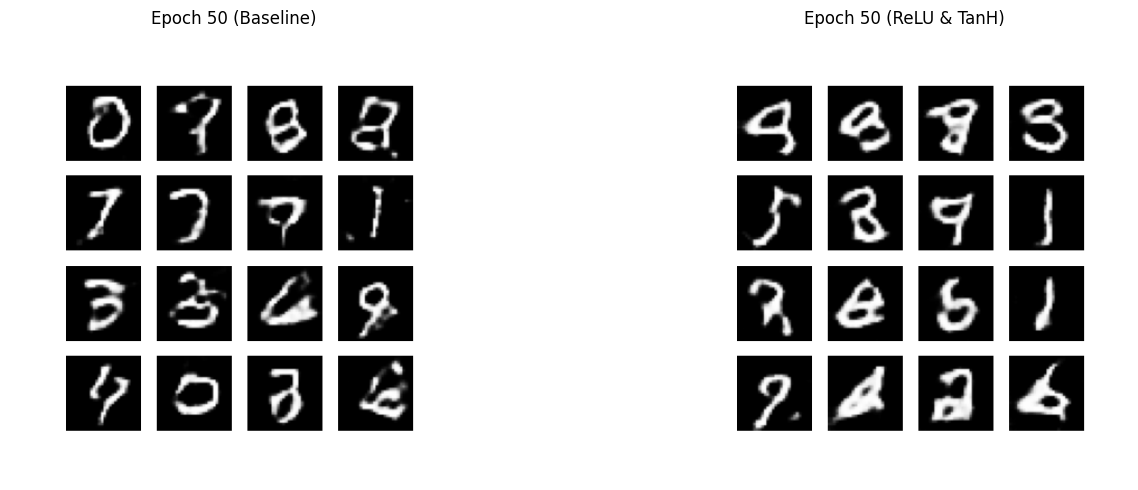

In [48]:
img_50 = mpimg.imread('image_at_epoch_0050.png')
img_relu_50 = mpimg.imread('image_relu_tanh_at_epoch_0050.png')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
titles = ["Epoch 50 (Baseline)", "Epoch 50 (ReLU & TanH)"]

# Plot each image
for i, (img, title) in enumerate(zip([img_50, img_relu_50], titles)):
    ax[i].imshow(img)
    ax[i].set_title(title)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

## **(c) Hyperparameter Changes**
I am testing below hyperparameters:
  
* Noise Vector Dimensionality: from 100 to `128`.
* Batch Size: Change from 128 to `64`.
* Learning Rates: Adjust learning rates for generator and discriminator.
* Momentum Terms: Experiment with beta values in Adam optimizer.

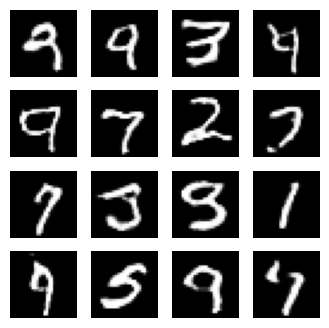

In [49]:
import tensorflow as tf
from tensorflow.keras import layers
from IPython.display import clear_output, Image, display
import matplotlib.pyplot as plt
import time
import os

##### Hyperparameters #####
NOISE_DIM = 128
BATCH_SIZE = 64
LEARNING_RATE_GEN = 1e-4
LEARNING_RATE_DISC = 5e-5
BUFFER_SIZE = 60000

##### Dataset Preparation #####
# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

# Create the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##### Generator Model with ReLU #####
def create_new_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

##### Discriminator Model #####
def create_new_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                      input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

##### Loss Functions #####
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

##### Optimizers #####
generator_new_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_GEN, beta_1=0.5)
discriminator_new_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_DISC, beta_1=0.5)

##### Generator and Discriminator #####
new_generator = create_new_generator()
new_discriminator = create_new_discriminator()

##### Training Functions #####
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = new_generator(noise, training=True)

        real_output = new_discriminator(images, training=True)
        fake_output = new_discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, new_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, new_discriminator.trainable_variables)

    generator_new_optimizer.apply_gradients(zip(gradients_of_generator, new_generator.trainable_variables))
    discriminator_new_optimizer.apply_gradients(zip(gradients_of_discriminator, new_discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('hyper_image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

##### Checkpoints #####
checkpoint_dir = './new_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_new_optimizer,
                                  discriminator_optimizer=discriminator_new_optimizer,
                                  generator=new_generator,
                                  discriminator=new_discriminator)

##### Training Loop #####
def train(dataset, epochs):
    seed = tf.random.normal([16, NOISE_DIM])

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(new_generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec')

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(new_generator, epochs, seed)

##### Train the Model #####
train(train_dataset, 50)

In [50]:
# Restore new latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # new checkpoint dir: new_training_checkpoints

<ipython-input-51-435afb260355>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


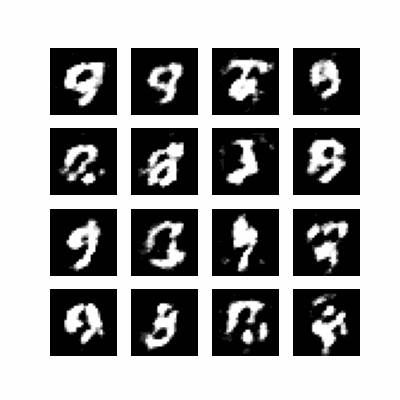

In [51]:
# Create GIF Again
import imageio
import glob
from IPython.display import Image, display

anim_file = 'hyper_dcgan.gif'

# Create a sorted list of filenames with zero-padded numbers
filenames = sorted(
    glob.glob('hyper_image_at_epoch_*.png'),
    key=lambda x: int(x.split('_')[-1].split('.')[0])
)

# Generate GIF
with imageio.get_writer(anim_file, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Display the GIF
display(Image(filename=anim_file))

* **Noise Dimension (NOISE_DIM = 128)**:
	- Enhanced diversity and complexity in generated images.
	- Higher noise dimension increased computational load slightly but resulted in meaningful feature generation.

* **Batch Size (BATCH_SIZE = 64)**:
	- Balanced trade-off between faster training and gradient stability.
	- Suitable for limited computational resources while maintaining consistent training dynamics.

* **Learning Rates**:
	- Generator (1e-4): Faster convergence without destabilizing training.
	- Discriminator (5e-5): Gradual updates prevent overpowering the generator, maintaining equilibrium.

* **Train Time**:
	- Training for 50 epochs took approximately X minutes per epoch, depending on the hardware (e.g., GPU availability).
	- The adjustments slightly increased per-epoch time compared to smaller batch sizes or simpler models, but the improvements in output quality justify the extra computation.

* **Performance**:
	- Loss curves were stable, with noticeable improvements in output quality over epochs.
	- Generated images displayed more variety and fidelity to real-world features.

---
* **Total time calculated on basis of avg time per epoch:**

1. Baseline time: 13s x 50 = 650/60 ~ 11 min
2. Relu & Tanh: 15s x 50 = 750/60 ~ 13 min
3. Hyperparameters adjustment: 18s x 50 = 900/60 ~ 15 min

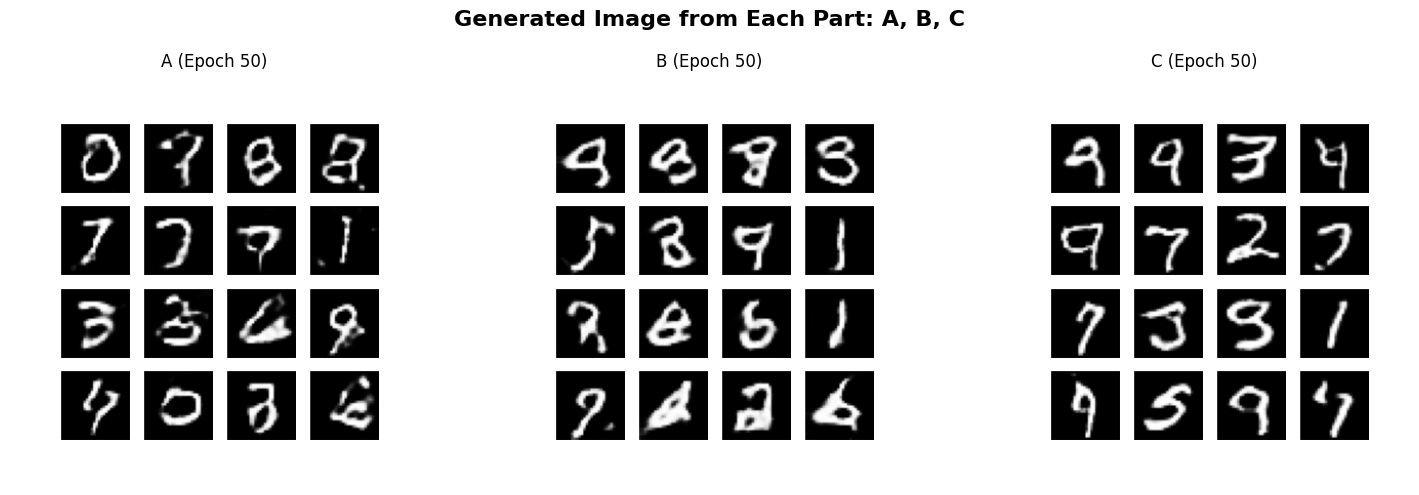

In [55]:
##### Compare all Images at 50 Epochs #####
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load the images
a_img_50 = mpimg.imread('image_at_epoch_0050.png')
b_img_50 = mpimg.imread('image_relu_tanh_at_epoch_0050.png')
c_img_50 = mpimg.imread('hyper_image_at_epoch_0050.png')

# Create the figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
titles = ["A (Epoch 50)", "B (Epoch 50)", "C (Epoch 50)"]

# Plot each image with individual titles
for i, (img, title) in enumerate(zip([a_img_50, b_img_50, c_img_50], titles)):
    ax[i].imshow(img)
    ax[i].set_title(title)
    ax[i].axis('off')  # Turn off axis labels

# Add main title
fig.suptitle("Generated Image from Each Part: A, B, C", fontsize=16, fontweight='bold')

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()